In [19]:
import json
import sys
sys.path.append('../')
from utils.core import np_ify, torch_ify
from trainer.particle_trainer import ParticleTrainer
from trainer.gaussian_trainer import GaussianTrainer
import numpy as np
import torch
from main import env_producer, get_policy_producer, get_q_producer
import matplotlib.pyplot as plt
from utils.pythonplusplus import load_gzip_pickle
import argparse
import pickle
from matplotlib import gridspec
from replay_buffer import ReplayBuffer, ReplayBufferCount
from replay_buffer_no_resampling import ReplayBufferNoResampling
import utils.pytorch_util as ptu
import random
from torchviz import make_dot

In [40]:
base_dir = 'data/global/riverswim/p-oac_/1589119566.6764867/'
base_dir = 'data/global/riverswim/g-oac_/1589120506.3212998/'
def plot_graph(base_dir, iter=23):
    path = base_dir + 'variant.json'
    variant = json.load(open(path, 'r'))
    domain = variant['domain']
    seed = variant['seed']
    r_max = variant['r_max']
    ensemble = variant['ensemble']
    delta = variant['delta']
    alg = variant['alg']
    n_estimators = variant['n_estimators']
    mean_update = variant['trainer_kwargs']['mean_update']
    if seed == 0:
        np.random.seed()
        seed = np.random.randint(0, 1000000)
    torch.manual_seed(seed)
    np.random.seed(seed)
    env_args = {}
    if domain in ['riverswim']:
        env_args['dim'] = variant['dim']
    expl_env = env_producer(domain, seed, **env_args)
    obs_dim = expl_env.observation_space.low.size
    action_dim = expl_env.action_space.low.size
    # Get producer function for policy and value functions
    M = variant['layer_size']
    N = variant['num_layers']
    n_estimators = variant['n_estimators']
    if variant['share_layers']:
        output_size = n_estimators
    else:
        output_size = 1
    q_producer = get_q_producer(obs_dim, action_dim, hidden_sizes=[M] * N, output_size=output_size)
    policy_producer = get_policy_producer(
        obs_dim, action_dim, hidden_sizes=[M] * N)
    q_min = variant['r_min'] / (1 - variant['trainer_kwargs']['discount'])
    q_max = variant['r_max'] / (1 - variant['trainer_kwargs']['discount'])
    if alg == 'p-oac':
        trainer_producer = ParticleTrainer
    else:
        trainer_producer = GaussianTrainer
    trainer = trainer_producer(
        policy_producer,
        q_producer,
        n_estimators=n_estimators,
        delta=variant['delta'],
        q_min=q_min,
        q_max=q_max,
        action_space=expl_env.action_space,
        ensemble=variant['ensemble'],
        n_policies=variant['n_policies'],
        **variant['trainer_kwargs']
    )
    experiment = base_dir + '/itr_' + str(iter) + '.zip_pkl'
    exp = load_gzip_pickle(experiment)
    trainer.restore_from_snapshot(exp['trainer'])
    if variant['alg'] in ['p-oac', 'g-oac', 'g-tsac', 'p-tsac'] and variant['trainer_kwargs']["counts"]:
        replay_buffer = ReplayBufferCount(
            variant['replay_buffer_size'],
            ob_space=expl_env.observation_space,
            action_space=expl_env.action_space,
            priority_sample=variant['priority_sample']
        )
    elif variant["no_resampling"] and variant['alg'] in ['p-oac', 'g-oac', 'g-tsac', 'p-tsac']:
        replay_buffer = ReplayBufferNoResampling(
            variant['replay_buffer_size'],
            ob_space=expl_env.observation_space,
            action_space=expl_env.action_space
        )
    else:
        replay_buffer = ReplayBuffer(
            variant['replay_buffer_size'],
            ob_space=expl_env.observation_space,
            action_space=expl_env.action_space
        )
    replay_buffer.restore_from_snapshot(exp['replay_buffer'])
    dataset = np.copy(replay_buffer.get_dataset())
    random.shuffle(dataset)
    states = torch_ify(dataset[:])
    target_actions, policy_mean, policy_log_std, log_pi, *_ = trainer.policy(
                        obs=states, reparameterize=True, return_log_prob=True, deterministic=True
                    )
    obj = trainer.obj_func(states, target_actions, upper_bound=True)
    policy_loss = (-obj).mean()
    make_dot(policy_loss)

In [37]:
q_producer = get_q_producer(obs_dim, action_dim, hidden_sizes=[M] * N, output_size=output_size)
policy_producer = get_policy_producer(
    obs_dim, action_dim, hidden_sizes=[M] * N)
q_min = variant['r_min'] / (1 - variant['trainer_kwargs']['discount'])
q_max = variant['r_max'] / (1 - variant['trainer_kwargs']['discount'])
if alg == 'p-oac':
    trainer_producer = ParticleTrainer
else:
    trainer_producer = GaussianTrainer
trainer = trainer_producer(
    policy_producer,
    q_producer,
    n_estimators=n_estimators,
    delta=variant['delta'],
    q_min=q_min,
    q_max=q_max,
    action_space=expl_env.action_space,
    ensemble=variant['ensemble'],
    n_policies=variant['n_policies'],
    **variant['trainer_kwargs']
)
iter = 23
delta_iter = 1
max_iter = 200
num_trains = variant['algorithm_kwargs']['num_trains_per_train_loop']
save_sampled_data = variant['algorithm_kwargs']['save_sampled_data']
if save_sampled_data:
    all_sampled_states = pickle.load(open(base_dir + '/sampled_states.pkl', 'rb'))
    all_sampled_actions = pickle.load(open(base_dir + '/sampled_actions.pkl', 'rb'))
experiment = base_dir + '/itr_' + str(iter) + '.zip_pkl'
exp = load_gzip_pickle(experiment)
trainer.restore_from_snapshot(exp['trainer'])




In [38]:
if variant['alg'] in ['p-oac', 'g-oac', 'g-tsac', 'p-tsac'] and variant['trainer_kwargs']["counts"]:
    replay_buffer = ReplayBufferCount(
        variant['replay_buffer_size'],
        ob_space=expl_env.observation_space,
        action_space=expl_env.action_space,
        priority_sample=variant['priority_sample']
    )
elif variant["no_resampling"] and variant['alg'] in ['p-oac', 'g-oac', 'g-tsac', 'p-tsac']:
    replay_buffer = ReplayBufferNoResampling(
        variant['replay_buffer_size'],
        ob_space=expl_env.observation_space,
        action_space=expl_env.action_space
    )
else:
    replay_buffer = ReplayBuffer(
        variant['replay_buffer_size'],
        ob_space=expl_env.observation_space,
        action_space=expl_env.action_space
    )
replay_buffer.restore_from_snapshot(exp['replay_buffer'])

torch.Size([10000, 1])
torch.Size([])


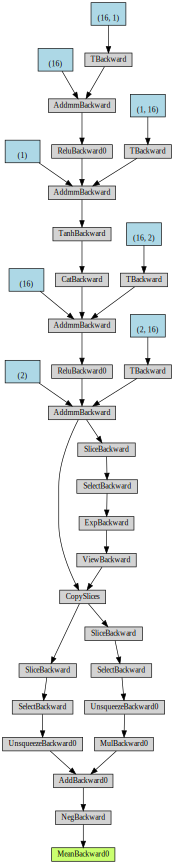

In [39]:
dataset = np.copy(replay_buffer.get_dataset())
random.shuffle(dataset)
states = torch_ify(dataset[:])
print(states.shape)
target_actions, policy_mean, policy_log_std, log_pi, *_ = trainer.policy(
                    obs=states, reparameterize=True, return_log_prob=True, deterministic=True
                )
obj = trainer.obj_func(states, target_actions, upper_bound=True)
policy_loss = (-obj).mean()
print(policy_loss.shape)
make_dot(policy_loss)

In [35]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('logs/exp-1')
writer.add_scalar('loss',policy_loss, 0)
input_ = dict(obs=states, 
             reparameterize=True, 
             return_log_prob=True, 
             deterministic=True)
writer.add_graph(trainer.policy, input_to_model=(states, ))
writer.export_scalars_to_json("logs/exp-1/all_scalars.json")
writer.close()

/usr/local/lib/python3.6/dist-packages/torch/jit/__init__.py:1044: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[792, 0] (-0.995018720626831 vs. 0.9906972050666809) and 9999 other locations (100.00%)
  check_tolerance, _force_outplace, True, _module_class)


In [42]:
base_dir = 'data/global/riverswim/g-oac_/1589200541.5921152/'
plot_graph(base_dir, iter=25)

/home/amarildo/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


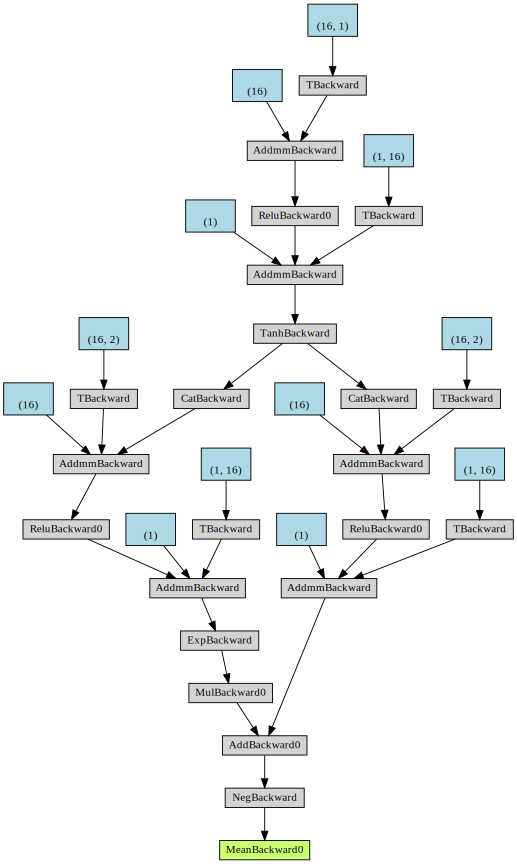

In [44]:
base_dir = 'data/global/riverswim/g-oac_/1589200541.5921152/'
iter = 20
path = base_dir + 'variant.json'
variant = json.load(open(path, 'r'))
domain = variant['domain']
seed = variant['seed']
r_max = variant['r_max']
ensemble = variant['ensemble']
delta = variant['delta']
alg = variant['alg']
n_estimators = variant['n_estimators']
mean_update = variant['trainer_kwargs']['mean_update']
if seed == 0:
    np.random.seed()
    seed = np.random.randint(0, 1000000)
torch.manual_seed(seed)
np.random.seed(seed)
env_args = {}
if domain in ['riverswim']:
    env_args['dim'] = variant['dim']
expl_env = env_producer(domain, seed, **env_args)
obs_dim = expl_env.observation_space.low.size
action_dim = expl_env.action_space.low.size
# Get producer function for policy and value functions
M = variant['layer_size']
N = variant['num_layers']
n_estimators = variant['n_estimators']
if variant['share_layers']:
    output_size = n_estimators
else:
    output_size = 1
q_producer = get_q_producer(obs_dim, action_dim, hidden_sizes=[M] * N, output_size=output_size)
policy_producer = get_policy_producer(
    obs_dim, action_dim, hidden_sizes=[M] * N)
q_min = variant['r_min'] / (1 - variant['trainer_kwargs']['discount'])
q_max = variant['r_max'] / (1 - variant['trainer_kwargs']['discount'])
if alg == 'p-oac':
    trainer_producer = ParticleTrainer
else:
    trainer_producer = GaussianTrainer
trainer = trainer_producer(
    policy_producer,
    q_producer,
    n_estimators=n_estimators,
    delta=variant['delta'],
    q_min=q_min,
    q_max=q_max,
    action_space=expl_env.action_space,
    ensemble=variant['ensemble'],
    n_policies=variant['n_policies'],
    **variant['trainer_kwargs']
)
experiment = base_dir + '/itr_' + str(iter) + '.zip_pkl'
exp = load_gzip_pickle(experiment)
trainer.restore_from_snapshot(exp['trainer'])
if variant['alg'] in ['p-oac', 'g-oac', 'g-tsac', 'p-tsac'] and variant['trainer_kwargs']["counts"]:
    replay_buffer = ReplayBufferCount(
        variant['replay_buffer_size'],
        ob_space=expl_env.observation_space,
        action_space=expl_env.action_space,
        priority_sample=variant['priority_sample']
    )
elif variant["no_resampling"] and variant['alg'] in ['p-oac', 'g-oac', 'g-tsac', 'p-tsac']:
    replay_buffer = ReplayBufferNoResampling(
        variant['replay_buffer_size'],
        ob_space=expl_env.observation_space,
        action_space=expl_env.action_space
    )
else:
    replay_buffer = ReplayBuffer(
        variant['replay_buffer_size'],
        ob_space=expl_env.observation_space,
        action_space=expl_env.action_space
    )
replay_buffer.restore_from_snapshot(exp['replay_buffer'])
dataset = np.copy(replay_buffer.get_dataset())
random.shuffle(dataset)
states = torch_ify(dataset[:])
target_actions, policy_mean, policy_log_std, log_pi, *_ = trainer.policy(
                    obs=states, reparameterize=True, return_log_prob=True, deterministic=True
                )
obj = trainer.obj_func(states, target_actions, upper_bound=True)
policy_loss = (-obj).mean()
make_dot(policy_loss)